In [1]:
import os
import numpy as np
import tensorflow as tf
import h5py
import donkeycar as dk
from donkeycar.parts.datastore import TubGroup, Tub
%matplotlib inline
from matplotlib import pyplot as plt

import os
import json
import numpy as np
import cv2
import matplotlib.pyplot as plt
import glob
from PIL import Image, ImageDraw
%matplotlib inline

from tensorflow.python.keras.layers import Input, BatchNormalization
from tensorflow.python.keras.models import Model, load_model
from tensorflow.python.keras.layers import Convolution2D
from tensorflow.python.keras.layers import Dropout, Flatten, Dense

from moviepy.editor import *
import glob

import donkeybarn as barn

#location where to save datasets
data_dir = os.path.expanduser('~/donkey_data')

print(barn.__file__)

using donkey v2.5.1 ...
pygame 1.9.4
Hello from the pygame community. https://www.pygame.org/contribute.html
/home/wroscoe/code/donkey/donkeybarn/donkeybarn/__init__.py


In [2]:
data_dir = os.path.expanduser('/home/wroscoe/data/diyrobocar_races/')
hf_path = os.path.expanduser('~/data/all_tubs.h5')

In [4]:
from donkeycar.parts.keras import default_linear

In [5]:
from tensorflow.python.keras.callbacks import ModelCheckpoint, EarlyStopping
def train(model, X, Y, saved_model_path, epochs=100, 
          min_delta=.0005, patience=3, use_early_stop=True):
    
    # checkpoint to save model after each epoch
    save_best = ModelCheckpoint(saved_model_path,
                                monitor='val_loss',
                                verbose=1,
                                save_best_only=True,
                                mode='min')

    # stop training if the validation error stops improving.
    early_stop = EarlyStopping(monitor='val_loss',
                               min_delta=min_delta,
                               patience=patience,
                               verbose=1,
                               mode='auto')

    callbacks_list = [save_best]

    if use_early_stop:
        callbacks_list.append(early_stop)

    hist = model.fit(
        X, Y,
        validation_split=.1,
        epochs=epochs,
        verbose=1,
        callbacks=callbacks_list)
    return hist

### Test the performance of the base model

In [6]:
BASE_MODEL_PATH = '/home/wroscoe/data/base_model.h5'
TUB_PATH = '/home/wroscoe/data/diyrobocar_races/2018-05_san_mateo_maker_faire/tub3'

In [18]:
tub = Tub(TUB_PATH)
data_dict = next(tub.get_batch_gen(batch_size = len(tub.get_index())))

img = data_dict['cam/image_array']
ang = data_dict['user/angle']
thr = data_dict['user/throttle']


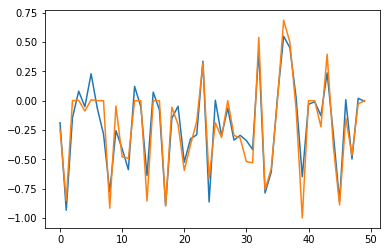

In [12]:
model = tf.keras.models.load_model(BASE_MODEL_PATH)
ang_p, thr_p = model.predict(img)

start=0
end=50
plt.plot(ang_p[start:end])
plt.plot(ang[start:end])

### Train for a new track starting with the base model

In [14]:
REFINED_MODEL_PATH='/home/wroscoe/data/refined_model.h5'

In [15]:
np.random.seed(42)
np.random.shuffle(img)
np.random.seed(42)

X = img
Y = {'angle_out': ang, 'throttle_out': thr}

In [19]:
train(model, X, Y, saved_model_path=REFINED_MODEL_PATH)

Train on 8956 samples, validate on 996 samples
Epoch 1/100
8956/8956 [==============================] - 4s 417us/step - loss: 0.0155 - angle_out_loss: 0.0228 - throttle_out_loss: 0.0082 - val_loss: 0.0128 - val_angle_out_loss: 0.0178 - val_throttle_out_loss: 0.0077

Epoch 00001: val_loss improved from inf to 0.01279, saving model to /home/wroscoe/data/refined_model.h5
Epoch 2/100
8956/8956 [==============================] - 3s 374us/step - loss: 0.0095 - angle_out_loss: 0.0129 - throttle_out_loss: 0.0061 - val_loss: 0.0103 - val_angle_out_loss: 0.0142 - val_throttle_out_loss: 0.0063

Epoch 00002: val_loss improved from 0.01279 to 0.01026, saving model to /home/wroscoe/data/refined_model.h5
Epoch 3/100
8956/8956 [==============================] - 3s 376us/step - loss: 0.0067 - angle_out_loss: 0.0086 - throttle_out_loss: 0.0047 - val_loss: 0.0113 - val_angle_out_loss: 0.0175 - val_throttle_out_loss: 0.0051

Epoch 00003: val_loss did not improve from 0.01026
Epoch 4/100
8956/8956 [=======

In [20]:
refined_model = tf.keras.models.load_model(REFINED_MODEL_PATH)

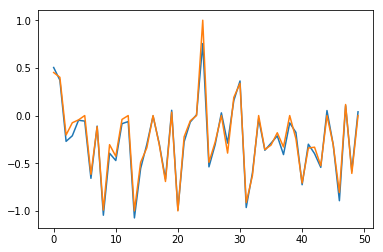

In [21]:
model = tf.keras.models.load_model(REFINED_MODEL_PATH)
ang_p, thr_p = model.predict(img)

start=0
end=50
plt.plot(ang_p[start:end])
plt.plot(ang[start:end])

In [ ]:
class AugmentPipeline:
    def __init__(self, data):
        self.data = data
        self.pipeline = []

    def add(self, processor, input_keys=[], chance=.2):
        self.pipeline.append(
            {'processor': processor,
             'input_keys': input_keys,
             'chance': chance})

    def run(self, gen_count=10):
        
        #TODO:
        # Create the output sample size
        # Apply the augmentations inplace column by column using np.putmask
        
        output_data = dict((k,[]) for k in data.keys())

        for i in range(gen_count):
            row_num = np.random.randint(0, len(self.data))
        
        # run row of data through pipeline
        for p in self.pipeline:

            # only run pipeline step if chance test succedes
            if p['chance'] > random.random():

                # get inputs
                inputs = []
                for input_key in p['input_keys']:
                    inputs.append(row[input_key])

                # run processor
                result = p['processor'].run(inputs)

                for i, output_ix in enumerate(p['input_keys']):
                    row[output_ix] = result[i]

        return row